In [1]:
from IPython.display import clear_output
# import pipreqsnb  # python reqs

import holidays
import geopandas
import pandas as pd
from pandasql import sqldf
import numpy as np
from pandarallel import pandarallel
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import norm, boxcox_normmax, yeojohnson
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import glob
import pickle
import zipfile

import os
import datetime
import warnings
from pathlib import Path
import logging
import requests
import json
import asyncio
from tqdm import tqdm

from Functions import *
from ETL import *

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=True)
np.random.seed(42)
sns.set(rc={'figure.figsize': (20, 10)})
sns.set_palette("viridis")
pysqldf = lambda q: sqldf(q, globals())

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


 The main objective is to develop mathematical model(s) that could work in 4 scenarios:
1) Define dynamics (amount) of booked flights by booking class (Saloons (SSC)) (2017-2019 y.)
2) Define seasonality of demand by booking class (2017-2019 y.)
3) Define profiles (segments of clients - b2b/b2c) by booking class (2017-2019 y.)
4) Predict demand (amount of people wanting to buy tickets) by booking class and flight (forecast horizon 2019 validation and 2020 test)

Moreover, there are 5 forecast types (each of them might require a different model):
1) Operative
2) Short-term
3) Mid-term
4) Long-term
5) Very long-term

See details in specification

# Getting and Transforming Data

In [2]:
# Main datasets provided by Aeroflot
cabin_history = pd.read_pickle("../AeroflotForecast/data/processed/cabin_history")
rasp_history = pd.read_pickle("../AeroflotForecast/data/processed/rasp_history")
class_history = pd.read_pickle("../AeroflotForecast/data/processed/class_history")

In [3]:
cabin_history = cabin_history.iloc[:100000]
rasp_history = rasp_history.iloc[:100000]
class_history = class_history.iloc[:1000000]

In [4]:
for categorical_column in cabin_history.select_dtypes('category').columns:
    # if categorical_column not in ['DEP_DATE', 'DAT_S']:
    cabin_history[categorical_column] = cabin_history[categorical_column].str.strip()

cabin_history["TT_DEP_HRS"] = cabin_history["TT_DEP"] / 100  # Local Hour of Departure
# cabin_history["TT_DEP_MIN"] = cabin_history["TT_DEP"] % 100  # Local Minute of Departure
cabin_history["TT_ARR_HRS"] = cabin_history["TT_ARR"] / 100  # Local Hour of Arrival
# cabin_history["TT_ARR_MIN"] = cabin_history["TT_ARR"] % 100  # Local Minute of Arrival

cabin_history['DEP_DATE'] = pd.to_datetime(cabin_history['DEP_DATE'])
cabin_history['DAT_S'] = pd.to_datetime(cabin_history['DAT_S'])

cabin_history['DEP_DATE_MONTH'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.month
cabin_history['DEP_DATE_DAY'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.day
cabin_history['DEP_DATE_WEEK'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.week
cabin_history['DEP_DATE_YEAR'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.year

# cabin_history['route'] = cabin_history[['SEG_ORIG', 'SEG_DEST']].parallel_apply("".join, axis=1)

cabin_history = reduce_memory_usage(cabin_history)

Memory usage of dataframe is 13.07 MB
Memory usage became:  4.185020446777344  MB


In [5]:
for categorical_column in class_history.select_dtypes('category').columns:
    # if categorical_column not in ['DD', 'SDAT_S']:
    class_history[categorical_column] = class_history[categorical_column].str.strip()
        
# class_history['route'] = class_history[['SORG', 'SDST']].parallel_apply("".join, axis=1)  
class_history['DD'] = pd.to_datetime(class_history['DD'])
class_history['SDAT_S'] = pd.to_datetime(class_history['SDAT_S'])

class_history['DD_month'] = pd.to_datetime(class_history['DD']).dt.month
class_history['DD_dayofyear'] = pd.to_datetime(class_history['DD']).dt.dayofyear
class_history['DD_day'] = pd.to_datetime(class_history['DD']).dt.day
class_history['DD_week'] = pd.to_datetime(class_history['DD']).dt.week
class_history['DD_year'] = pd.to_datetime(class_history['DD']).dt.year

class_history['SDAT_S_month'] = pd.to_datetime(class_history['SDAT_S']).dt.month
class_history['SDAT_S_dayofyear'] = pd.to_datetime(class_history['SDAT_S']).dt.dayofyear
class_history['SDAT_S_week'] = pd.to_datetime(class_history['SDAT_S']).dt.week
class_history['SDAT_S_year'] = pd.to_datetime(class_history['SDAT_S']).dt.year

class_history = reduce_memory_usage(class_history)     

Memory usage of dataframe is 144.00 MB
Memory usage became:  47.685707092285156  MB


# Downloading External Datasets

- Dataset with airports' coordinates and data
- Dataset with weather history
- Dataset with world's cities main description
- Dataset with attractions in Russian cities (further on embeddings can be used to assess their importance). International cities should also be added in the future

Downloading dynamically when forecasting:
- NOW IS NOT RELEVANT Weather forecast (python_weather)

In [6]:
# airports data
with open('../AeroflotForecast/data/external/airports_data_airportsdata.json') as airports_json:
    airports_data = pd.DataFrame.from_dict(json.load(airports_json), orient='index').reset_index(drop=True)
airports_data.head(2)

,icao,iata,name,city,subd,country,elevation,lat,lon,tz,lid
0,19AK,ICY,Icy Bay Airport,Icy Bay,Alaska,US,50.0,59.969019,-141.661770,America/Anchorage,19AK
1,2AK6,HGZ,Hog River Airport,Hogatza,Alaska,US,534.0,66.176133,-155.684817,America/Anchorage,2AK6


In [7]:
# weather data at airports
# air = get_observed_weather_data(airports_data.query("country == 'RU'"),
#                           '2017-01-01',
#                           '2020-01-01')
# air.to_pickle("../AeroflotForecast/data/external/airports_weather_data.pkl")
airports_weather_data = pd.read_pickle("../AeroflotForecast/data/external/airports_weather_data.pkl")
airports_weather_data['month'] = airports_weather_data['time'].dt.month
airports_weather_data['year'] = airports_weather_data['time'].dt.year
airports_weather_data['day'] = airports_weather_data['time'].dt.day
airports_weather_data['week'] = airports_weather_data['time'].dt.week
airports_weather_data = airports_weather_data.astype({'time': 'str'})
airports_weather_data.head(2)

,iata,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,index,station,month,year,day,week
0,ADH,2017-01-01,-16.7,-20.4,-13.9,0.4,551.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2017,1,52
1,ADH,2017-01-02,-16.5,-19.6,-13.5,0.2,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2017,2,1


In [8]:
# cities data
cities_data = pd.read_excel("../AeroflotForecast/data/external/world_cities_data.xlsx")
cities_data[cities_data['country'] == 'Russia'].reset_index(drop=True).head(2)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Moscow,Moscow,55.7558,37.6178,Russia,RU,RUS,Moskva,primary,17332000.0,1643318494
1,Saint Petersburg,Saint Petersburg,59.9500,30.3167,Russia,RU,RUS,Sankt-Peterburg,admin,5384342.0,1643616350


In [9]:
# tourist attractions in Russia
attractions_data = pd.read_csv("../AeroflotForecast/data/external/russia_tourist_attractions_data.csv")
attractions_data['city'] = (attractions_data['locality'].combine_first(attractions_data['region'])).str.replace(" region", "")
attractions_cities = attractions_data.groupby('city', as_index=False).agg(qnt=('name', 'count'))
attractions_cities.sort_values(by='qnt', ascending=False, ignore_index=True).head(2)

,city,qnt
0,St. Petersburg,243
1,Moscow,176


In [10]:
# Russian holidays
get_russian_holidays = holidays.country_holidays('RU')

temp_holidays_dates = []
temp_holidays_names = []

for date in pd.date_range(start='2017-01-01', end='2021-01-01'):
    holiday_name = get_russian_holidays.get(date)
    if holiday_name:
        temp_holidays_dates.append(date)
        temp_holidays_names.append(holiday_name)

russian_holidays = pd.DataFrame(list(zip(temp_holidays_dates, temp_holidays_names)), columns=['date', 'holiday'])
russian_holidays.head(3)

,date,holiday
0,2017-01-01,New Year Holidays
1,2017-01-02,New Year Holidays
2,2017-01-03,New Year Holidays


In [11]:
# Rosavia historical data
market = pd.read_excel("../AeroflotForecast/data/external/rosaviation_market_data.xlsx")
market

,year,month,market
0,2014,Jan,5863903
1,2014,Feb,5333622
2,2014,Mar,6224523
3,2014,Apr,6440361
4,2014,May,7933068
...,...,...,...
91,2021,Aug,13950857
92,2021,Sep,12335380
93,2021,Oct,11001489
94,2021,Nov,8227798


# Exploratory Data Analysis

## Cabin DataFrame Exploration

DataFrame Description:
<span style="font-size:14px; font-family:Verdana;"> Data by flights and cabins (saloons) </span>

|No  | Column name                             | Meaning                                                                  |
|:---|:----------------------------------------|:-------------------------------------------------------------------------|
| 1  | <font color="#B2DDF7"> DAT_S </font>    | Date of Recording                                                              |
| 2  | <font color="#B2DDF7"> SAK </font>      | Airlines IATA Code                                                       |
| 3  | <font color="#B2DDF7"> FLT_NUM </font>  | Flight Number                                                            |
| 4  | <font color="#B2DDF7"> DEP_DATE </font> | Departure Date                                                           |
| 5  | <font color="#B2DDF7"> LGNUM </font>    | Leg Number                                                               |
| 6  | <font color="#B2DDF7"> SEG_ORIG </font> | Airport of Origin IATA Code                                           |
| 7  | <font color="#B2DDF7"> SEG_DEST </font> | Airport of Destination IATA Code                                             |
| 8  | <font color="#B2DDF7"> TT_DEP </font>   | Local Time of Departure (format HHMM)                                    |
| 9  | <font color="#B2DDF7"> TT_ARR </font>   | Local Time of Arrival (format HHMM)                                      |
| 10  | <font color="#B2DDF7"> SSC </font>      | Saloons                                                                  |
| 11  | <font color="#B2DDF7"> CAP </font>      | Aircraft Capacity (Configuration)                                        |
| 12  | <font color="#B2DDF7"> UAL </font>      | Level of Authorization by saloon (chairs put on sales incl. overbooking) |
| 13  | <font color="#B2DDF7"> SAL </font>      | Available Chairs by Saloons                                              |
| 14  | <font color="#B2DDF7"> EQUIP  </font>   | Aircraft Type                                                            |
| 15  | <font color="#B2DDF7"> DTD  </font>     | Days till Departure (Booking Window)                                     |

Total number of entries: 4,264,715

In [12]:
print("Number of entries: {:,d}".format(len(cabin_history)))

Number of entries: 100,000


Посмотрим на предоставленые данные в резрезе кабин

In [13]:
cabin_history.head()

,DAT_S,SAK,FLT_NUM,DEP_DATE,LGNUM,SEG_ORIG,SEG_DEST,TT_DEP,TT_ARR,SSC,...,UAL,SAL,EQUIP,DTD,TT_DEP_HRS,TT_ARR_HRS,DEP_DATE_MONTH,DEP_DATE_DAY,DEP_DATE_WEEK,DEP_DATE_YEAR
0,2018-03-01,SU,1120,2018-02-01,1,SVO,AER,140,410,J /Y,...,12/77,8/9,SU9,-1,1.400391,4.101562,2,1,5,2018
1,2018-02-01,SU,1120,2018-02-01,1,SVO,AER,140,410,J /Y,...,12/77,8/9,SU9,0,1.400391,4.101562,2,1,5,2018
2,2018-01-01,SU,1120,2018-02-01,1,SVO,AER,140,410,J /Y,...,12/77,8/4,SU9,1,1.400391,4.101562,2,1,5,2018
3,2017-12-31,SU,1120,2018-02-01,1,SVO,AER,140,410,J /Y,...,12/77,7/7,SU9,2,1.400391,4.101562,2,1,5,2018
4,2017-12-30,SU,1120,2018-02-01,1,SVO,AER,140,410,J /Y,...,12/77,6/11,SU9,3,1.400391,4.101562,2,1,5,2018


In [14]:
show_dataframe_stat(cabin_history)

,data_type,nulls_qnt,nulls_share,non_nulls_qnt,cardinality
CAP,category,0,0.0,100000,7
DAT_S,datetime64[ns],0,0.0,100000,551
DEP_DATE,datetime64[ns],0,0.0,100000,363
DEP_DATE_DAY,int8,0,0.0,100000,31
DEP_DATE_MONTH,int8,0,0.0,100000,12
DEP_DATE_WEEK,int8,0,0.0,100000,52
DEP_DATE_YEAR,int16,0,0.0,100000,1
DTD,int16,0,0.0,100000,219
EQUIP,category,0,0.0,100000,7
FLT_NUM,int16,0,0.0,100000,2


Как видно из кол-ва уникальных значений, столбцы SAK и LGNUM можно удалить из датасета, т.к. они не несут никакой полезной информации.

In [15]:
# fig = px.box(cabin_history, x="route", y="DTD") # , points="outliers"
# plotly.offline.plot(fig, filename='../AeroflotForecast/visualizations/boxplot_dtd_route')
# fig.show()

In [16]:
cabin_history.describe()

,FLT_NUM,LGNUM,TT_DEP,TT_ARR,DTD,TT_DEP_HRS,TT_ARR_HRS,DEP_DATE_MONTH,DEP_DATE_DAY,DEP_DATE_WEEK,DEP_DATE_YEAR
count,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0
mean,1120.320800,1.0,623.682700,862.441900,96.614300,NaN,NaN,6.223760,15.125420,25.062080,2018.0
std,0.466786,0.0,398.799557,383.082451,61.634799,0.000000,0.000000,3.462457,8.840223,15.001698,0.0
min,1120.000000,1.0,35.000000,255.000000,-1.000000,0.350098,2.550781,1.000000,1.000000,1.000000,2018.0
25%,1120.000000,1.0,140.000000,410.000000,43.000000,1.400391,4.101562,3.000000,7.000000,11.000000,2018.0
50%,1120.000000,1.0,610.000000,835.000000,91.000000,6.101562,8.351562,6.000000,15.000000,25.000000,2018.0
75%,1121.000000,1.0,935.000000,1155.000000,149.000000,9.351562,11.546875,9.000000,23.000000,38.000000,2018.0
max,1121.000000,1.0,1315.000000,1540.000000,217.000000,13.148438,15.398438,12.000000,31.000000,52.000000,2018.0


Dataset Insights:
- As it may be seen, there are only 4 routes: 'SVOAER', 'AERSVO', 'SVOASF', 'ASFSVO'
- Value DTD = -1 means that the recording was done after the flight. That is, when all factual information was recorded.

## Class DataFrame Exploration

DataFrame Description:
<span style="font-size:14px; font-family:Verdana;"> Data by booking classes </span>

| No  | Column name                                  | Meaning                                                                 |
|:----|:----------------------------------------------|:------------------------------------------------------------------------|
| 1   | <font color="#B2DDF7"> SDAT_S </font>         | Date of Recording                                                       |
| 2   | <font color="#B2DDF7"> SAK </font>            | Airlines IATA Code                                                      |
| 3   | <font color="#B2DDF7"> FLT_NUM </font>        | Flight Number                                                           |
| 4   | <font color="#B2DDF7"> DD </font>             | Departure Date                                                          |
| 5   | <font color="#B2DDF7"> SEG_NUM </font>        | Segment Number                                                          |
| 6   | <font color="#B2DDF7"> SORG </font>           | Airport of Departure IATA Code                                          |
| 7   | <font color="#B2DDF7"> SDST </font>           | Airport of Arrival IATA Code                                            |
| 8   | <font color="#B2DDF7"> SSCL1 </font>          | Saloons                                                                 |
| 9   | <font color="#B2DDF7"> SEG_CLASS_CODE </font> | Booking Class                                                           |
| 10  | <font color="#B2DDF7"> NBCL </font>           | Class position in nesting                                               |
| 11  | <font color="#B2DDF7"> FCLCLD </font>         | Flag that indicates whether class is closed (1) or opened (0) for sale |
| 12  | <font color="#B2DDF7"> PASS_BK </font>        | Amount of booked passengers                                             |
| 13  | <font color="#B2DDF7"> AU  </font>            | Available chairs by saloons                                             |
| 14  | <font color="#B2DDF7"> SA  </font>            | Level of Authorization (opened for sales incl. overbooking)             |
| 15  | <font color="#B2DDF7"> PASS_DEP  </font>      | Amount of flown passengers                                              |
| 16  | <font color="#B2DDF7"> NS  </font>            | No-show. Passengers that neither appeared, nor canceled their booking   |
| 17  | <font color="#B2DDF7"> DTD  </font>           | Days till Departure (Booking Window)                                    |

In [17]:
print("Number of entries: {:,d}".format(len(class_history)))

Number of entries: 1,000,000


In [18]:
class_history.head()

,SDAT_S,SAK,FLT_NUM,DD,SEG_NUM,SORG,SDST,SSCL1,SEG_CLASS_CODE,NBCL,...,DTD,DD_month,DD_dayofyear,DD_day,DD_week,DD_year,SDAT_S_month,SDAT_S_dayofyear,SDAT_S_week,SDAT_S_year
0,2018-02-01,SU,1125,2018-01-01,1,AER,SVO,C,J,,...,-1,1,1,1,1,2018,2,32,5,2018
1,2018-02-01,SU,1125,2018-01-01,1,AER,SVO,C,C,J,...,-1,1,1,1,1,2018,2,32,5,2018
2,2018-02-01,SU,1125,2018-01-01,1,AER,SVO,C,D,C,...,-1,1,1,1,1,2018,2,32,5,2018
3,2018-02-01,SU,1125,2018-01-01,1,AER,SVO,C,I,D,...,-1,1,1,1,1,2018,2,32,5,2018
4,2018-02-01,SU,1125,2018-01-01,1,AER,SVO,C,Z,I,...,-1,1,1,1,1,2018,2,32,5,2018


In [19]:
show_dataframe_stat(class_history)

,data_type,nulls_qnt,nulls_share,non_nulls_qnt,cardinality
AU,int16,0,0.0,1000000,262
DD,datetime64[ns],0,0.0,1000000,31
DD_day,int8,0,0.0,1000000,20
DD_dayofyear,int16,0,0.0,1000000,31
DD_month,int8,0,0.0,1000000,12
DD_week,int8,0,0.0,1000000,15
DD_year,int16,0,0.0,1000000,1
DTD,int16,0,0.0,1000000,219
FCLCLD,int8,0,0.0,1000000,2
FLT_NUM,int16,0,0.0,1000000,27


Как видно из таблицы выше, поля SAK и SEG_NUM не несут никакой инфы, можно удалить

In [20]:
# class_history.describe()

In [21]:
# for class_name in class_history.SEG_CLASS_CODE.unique():
#     class_days = class_history.query("(DTD == -1) & (PASS_DEP > 0) & (SEG_CLASS_CODE == @class_name)").groupby(["DD"], as_index=False)['PASS_DEP'].sum().query("PASS_DEP > 0")
#     class_days['DD'] = pd.to_datetime(class_days['DD'])
#     class_days = class_days.sort_values(by='DD').set_index('DD')
#     if len(class_days) > 30:
#         seasonal_decomposition = seasonal_decompose(class_days, model='multiplicative', period=7)
#         # plt.figure(figsize=(20,10))
#         fig = seasonal_decomposition.plot()
#         fig.suptitle(class_name, fontsize=20)
#         plt.ylabel('PASS_DEP', fontsize=16)
#         plt.xlabel('DD', fontsize=16)
#         fig.show()

In [22]:
class_history_subsample = class_history.groupby("SEG_CLASS_CODE").apply(lambda x: x.sample(frac=0.001))
# fig = px.box(class_history_subsample, x="SEG_CLASS_CODE", y="DTD") # , points="outliers"
# plotly.offline.plot(fig, filename='../AeroflotForecast/visualizations/boxplot_class_dtd_route')

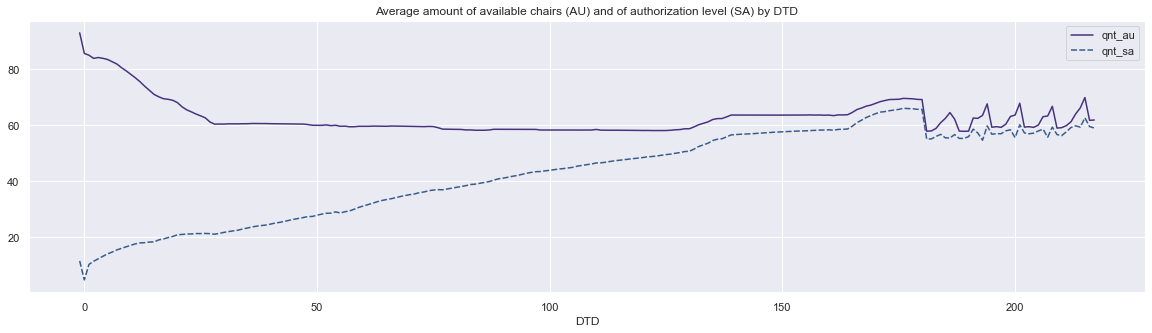

In [23]:
class_history_plot = class_history.groupby(['DTD']).agg(qnt_au=('AU', 'mean'), qnt_sa=('SA', 'mean'))

plt.figure(figsize=(20,5))
sns.lineplot(data=class_history_plot[['qnt_au', 'qnt_sa']])
plt.title("Average amount of available chairs (AU) and of authorization level (SA) by DTD")
plt.show()

Dataset insights:
- Field PASS_DEP is filled only for DTD = -1. Therefore, if we sum up PASS_DEP on DTD we receive factual amount of passangers
- На последнем графике видно, что около 60 дней до вылета начинается особенно активное бронирование мест.

# Training Dataset Ctreation and Feature Engineering

Model Feature for Training:
- Day of Departure / Date of recording month/weekday/week/dayofyear/hours
- FLT_NUM (one-hot encoding)
- holiday (one-hot encoding)
- SORG (one-hot encoding)
- SDST (one-hot encoding)
- SSCL1 - saloons. Might be important. For some reasons naming in CLASS_ and CABIN_ is different: Y/J vs Y/C
- FLT_FREQ_TOTAL and FLT_FREQ_MONTH - frequence of flights. This feature is very important
- AVG max temperature in the week/month of arrival at the area of arrival/departure. And the difference between them
- Seasonal component - total, of the route, of the booking class, and Rosavia data
- TODO Add season names

Other feature to consider and experiment (mostly cannot simply be used; some inventions are required):
- CAP_J - may be useful
- CAP_Y - may be useful
- UAL_J - may be useful
- UAL_Y - may be useful
- Amount of flights in the other side for the elapsed period of time. Can be very helpful
- EQUIP1 - should not be used. Instead, its capacity (features higher) could be the great fit
- SDAT_S - does not look useful as it echoes DTD
- overbooking_plan
- NS_other
- NS
- PASS_DEP
- FCLCLD - not clear how to interpret it
- Flight duration - not sure will improve score anyhow
- Field NBCL doesn't look to bring any extra value, given that we have feature SEG_CLASS_CODE

In [24]:
cabin_history.drop(columns=['LGNUM', 'SAK'], inplace=True)
class_history.drop(columns=['SAK', 'SEG_NUM'], inplace=True)

In [25]:
# flight frequency - average interval between flights
cabin_by_flt_num = cabin_history.groupby(['FLT_NUM'], as_index=False)\
                                .agg(DEP_DATE_MIN=('DEP_DATE', 'min'),
                                     DEP_DATE_MAX=('DEP_DATE', 'max'),
                                     FLT_QNT=('DEP_DATE', 'nunique'))
cabin_by_flt_num['days'] = (cabin_by_flt_num.DEP_DATE_MAX - cabin_by_flt_num.DEP_DATE_MIN).dt.days
cabin_by_flt_num['FLT_FREQ_TOTAL'] = cabin_by_flt_num['days'] / cabin_by_flt_num['FLT_QNT']

# let us get flights frequencies by months and years
cabin_by_flt_num_week  = cabin_history.groupby(['FLT_NUM', 'DEP_DATE_MONTH', 'DEP_DATE_YEAR'], as_index=False)\
                                      .agg(DEP_DATE_MIN=('DEP_DATE', 'min'),
                                           DEP_DATE_MAX=('DEP_DATE', 'max'),
                                           FLT_QNT=('DEP_DATE', 'nunique'))
cabin_by_flt_num_week['days'] = (cabin_by_flt_num_week.DEP_DATE_MAX - cabin_by_flt_num_week.DEP_DATE_MIN).dt.days
cabin_by_flt_num_week['FLT_FREQ_MONTH'] = cabin_by_flt_num_week['days'] / cabin_by_flt_num_week['FLT_QNT']

# let us get flights frequencies by months averaged over the years
cabin_by_flt_num_week_avg = cabin_by_flt_num_week.groupby(['FLT_NUM', 'DEP_DATE_MONTH'], as_index=False)\
                                                 .agg(FLT_FREQ_MONTH_AVG=('FLT_FREQ_MONTH', 'mean'))


# parsing of CAP values by saloons
cabin_history['CAP_J'] = 0
cabin_history['CAP_Y'] = 0
cabin_history.loc[~cabin_history.SSC.str.contains("J"), 'CAP_Y'] = cabin_history.CAP
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'CAP_J'] = cabin_history.CAP.str.split('/').str[0]
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'CAP_Y'] = cabin_history.CAP.str.split('/').str[1]

# parsing of UAL values by saloons
cabin_history['UAL_J'] = 0
cabin_history['UAL_Y'] = 0
cabin_history.loc[~cabin_history.SSC.str.contains("J"), 'UAL_Y'] = cabin_history.UAL
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'UAL_J'] = cabin_history.UAL.str.split('/').str[0]
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'UAL_Y'] = cabin_history.UAL.str.split('/').str[1]

cabin_history = cabin_history.astype({'UAL_Y': 'int', 'UAL_J': 'int', 'CAP_Y': 'int', 'CAP_J': 'int'})

# overbooking in percents
cabin_history['overbooking_plan_J'] = cabin_history['UAL_J'] / cabin_history['CAP_J']
cabin_history['overbooking_plan_Y'] = cabin_history['UAL_Y'] / cabin_history['CAP_Y']

# parsing of number of available seats by saloons
cabin_history['available_J'] = cabin_history.SAL.str.split('/').str[0]
cabin_history['available_Y'] = cabin_history.SAL.str.split('/').str[1]

cabin_history = reduce_memory_usage(cabin_history)

Memory usage of dataframe is 8.57 MB
Memory usage became:  5.240604400634766  MB


In [26]:
class_history.loc[class_history['DTD'] == -1, 'NS_other'] = class_history['PASS_BK'] - class_history['PASS_DEP'] - class_history['NS']
class_history.loc[class_history['NS_other'] < 0, 'NS_other'] = 0
class_history['demand'] = class_history['PASS_DEP'] + class_history['NS'] + class_history['NS_other']

In [27]:
# total seasonality
class_seasonality_by_dd = class_history.query("(DTD == -1) & (demand > 0)").groupby(["DD"], as_index=False)['demand'].sum()
class_seasonality_by_dd = class_seasonality_by_dd.sort_values(by='DD').set_index('DD')
seasonality_by_dd = seasonal_decompose(class_seasonality_by_dd, model='multiplicative', period=7).trend.reset_index()
seasonality_by_dd['month'] = seasonality_by_dd.DD.dt.month
seasonality_by_dd['day'] = seasonality_by_dd.DD.dt.day
seasonality_by_dd = seasonality_by_dd.groupby(['month', 'day'], as_index=False)['trend'].mean()

# booking class seasonality
seasonality_by_class = pd.DataFrame(columns=['class_name', 'day', 'month', 'trend'])
for class_name in class_history.SEG_CLASS_CODE.unique():
    class_days = class_history.query("(DTD == -1) & (demand > 0) & (SEG_CLASS_CODE == @class_name)").groupby(["DD"], as_index=False)['demand'].sum()
    class_days = class_days.sort_values(by='DD').set_index('DD')
     # 14 is the minimal days that are required to calculate seasonality
    if len(class_days) > 14:
        class_seasonality_by_class = seasonal_decompose(class_days, model='multiplicative', period=7).trend.reset_index()
        class_seasonality_by_class['month'] = class_seasonality_by_class.DD.dt.month
        class_seasonality_by_class['day'] = class_seasonality_by_class.DD.dt.day
        class_seasonality_by_class = class_seasonality_by_class.groupby(['month', 'day'], as_index=False)['trend'].mean()
        class_seasonality_by_class['class_name'] = class_name
        seasonality_by_class = pd.concat([seasonality_by_class, class_seasonality_by_class], ignore_index=True)
seasonality_by_class.fillna(method='ffill', inplace=True)

# booking class routes
routes = class_history[['SORG', 'SDST']].drop_duplicates().reset_index(drop=True)
seasonality_by_route = pd.DataFrame(columns=['SORG', 'SDST', 'day', 'month', 'trend'])
for _, (SORG, SDST) in routes.iterrows():
    class_days = class_history.query("(DTD == -1) & (demand > 0) & (SORG == @SORG) & (SDST == @SDST)").groupby(["DD"], as_index=False)['demand'].sum()
    class_days = class_days.sort_values(by='DD').set_index('DD')
    # 14 is the minimal days that are required to calculate seasonality
    if len(class_days) > 14:
        route_seasonality_by_route = seasonal_decompose(class_days, model='multiplicative', period=7).trend.reset_index()
        route_seasonality_by_route['month'] = route_seasonality_by_route.DD.dt.month
        route_seasonality_by_route['day'] = route_seasonality_by_route.DD.dt.day
        route_seasonality_by_route = route_seasonality_by_route.groupby(['month', 'day'], as_index=False)['trend'].mean()
        route_seasonality_by_route['SORG'] = SORG
        route_seasonality_by_route['SDST'] = SDST
        seasonality_by_route = pd.concat([seasonality_by_route, route_seasonality_by_route], ignore_index=True)
seasonality_by_route = seasonality_by_route.rename(columns={'trend': 'trend_route'})
seasonality_by_route.fillna(method='ffill', inplace=True)

In [28]:
%%time
def get_train_dataset(class_history):
    class_data = class_history.copy()
    train = class_data.merge(
        airports_weather_data.groupby(['iata', 'week'])['tmax'].mean(),
        left_on=['SORG', 'DD_week'],
        right_on=['iata', 'week'],
        how='left'
    ).merge(
        airports_weather_data.groupby(['iata', 'month'])['tmax'].mean(),
        left_on=['SORG', 'DD_month'],
        right_on=['iata', 'month'],
        how='left',
        suffixes=('_WEEK_SORG', '_MONTH_SORG')
    ).merge(
        airports_weather_data.groupby(['iata', 'week'])['tmax'].mean(),
        left_on=['SDST', 'DD_week'],
        right_on=['iata', 'week'],
        how='left'
    ).merge(
        airports_weather_data.groupby(['iata', 'month'])['tmax'].mean(),
        left_on=['SDST', 'DD_month'],
        right_on=['iata', 'month'],
        how='left',
        suffixes=('_WEEK_SDST', '_MONTH_SDST')
    ).merge(
        cabin_by_flt_num[['FLT_NUM', 'FLT_FREQ_TOTAL']],
        left_on=['FLT_NUM'],
        right_on=['FLT_NUM'],
        how='left'    
    ).merge(
        cabin_by_flt_num_week_avg[['FLT_NUM', 'DEP_DATE_MONTH', 'FLT_FREQ_MONTH_AVG']],
        left_on=['FLT_NUM', 'DD_month'],
        right_on=['FLT_NUM', 'DEP_DATE_MONTH'],
        how='left'    
    ).merge(
        russian_holidays,
        left_on=['DD'],
        right_on=['date'],
        how='left'    
    ).merge(
        russian_holidays,
        left_on=['SDAT_S'],
        right_on=['date'],
        how='left',
        suffixes=('_DD', '_SDAT_S')
    ).merge(
        seasonality_by_dd,
        left_on=['DD_month', 'DD_day'],
        right_on=['month', 'day'],
        how='left'
    ).merge(
        seasonality_by_class,
        left_on=['SEG_CLASS_CODE', 'DD_month', 'DD_day'],
        right_on=['class_name', 'month', 'day'],
        how='left',
        suffixes=('_total', '_class')
    ).merge(
        seasonality_by_route,
        left_on=['SORG', 'SDST', 'DD_month', 'DD_day'],
        right_on=['SORG', 'SDST', 'month', 'day'],
        how='left'
    )
    #.merge(
    #     cabin_history[['FLT_NUM', 'DEP_DATE','TT_DEP_HRS', 'TT_ARR_HRS']].drop_duplicates(),
    #     left_on=['FLT_NUM', 'DD'],
    #     right_on=['FLT_NUM', 'DEP_DATE'],
    #     how='left'    
    # )
    
    train.fillna(value={'holiday_DD': 0, 'holiday_SDAT_S': 0}, inplace=True)
    train[['trend_total', 'trend_class', 'trend_route']] = train[['trend_total', 'trend_class', 'trend_route']].fillna(method='ffill')

    train.drop(columns=['FLT_NUM', 'SDAT_S', 'DD', 'NBCL', 'FCLCLD', 'PASS_BK', 'SA', 'AU', 'PASS_DEP', 'NS', 'NS_other',
                        'date_DD', 'date_SDAT_S', 'class_name', 'day_class', 'month_total', 'day_total', 'month_class',
                        'day', 'month'], inplace=True)

    return reduce_memory_usage(train)

train = get_train_dataset(class_history.iloc[:10000])
# del class_history
train.to_pickle("aeroflot_train.pkl")
train = train.astype({'tmax_WEEK_SORG': 'int', 'tmax_MONTH_SORG': 'int',
                      'tmax_WEEK_SDST': 'int', 'tmax_MONTH_SDST': 'int'})
train.head()

Memory usage of dataframe is 1.45 MB
Memory usage became:  0.47815704345703125  MB
Wall time: 130 ms


,SORG,SDST,SSCL1,SEG_CLASS_CODE,DTD,DD_month,DD_dayofyear,DD_day,DD_week,DD_year,...,tmax_WEEK_SDST,tmax_MONTH_SDST,FLT_FREQ_TOTAL,DEP_DATE_MONTH,FLT_FREQ_MONTH_AVG,holiday_DD,holiday_SDAT_S,trend_total,trend_class,trend_route
0,AER,SVO,C,J,-1,1,1,1,1,2018,...,-3,-4,NaN,NaN,NaN,New Year Holidays,0,NaN,NaN,NaN
1,AER,SVO,C,C,-1,1,1,1,1,2018,...,-3,-4,NaN,NaN,NaN,New Year Holidays,0,NaN,73.312500,NaN
2,AER,SVO,C,D,-1,1,1,1,1,2018,...,-3,-4,NaN,NaN,NaN,New Year Holidays,0,NaN,9.710938,NaN
3,AER,SVO,C,I,-1,1,1,1,1,2018,...,-3,-4,NaN,NaN,NaN,New Year Holidays,0,NaN,9.710938,NaN
4,AER,SVO,C,Z,-1,1,1,1,1,2018,...,-3,-4,NaN,NaN,NaN,New Year Holidays,0,NaN,9.710938,NaN


In [29]:
# for Trees Transformation is not necessary (even discouraged)
# from sklearn.preprocessing import OneHotEncoder


# def transform_train(df_train):
#     OHEncoder = OneHotEncoder(handle_unknown='ignore', drop='first')

# ML Algorithm

Frontend Request - booking class (SEG_CLASS_CODE), flight (FLT_NUM), date to forecast from, forecast horizon\
Model Output - date, demand\
Write to DB -  date, booking class, flight, pred date, demand

In [30]:
# from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool, metrics
import shap
# from wandb.integration.catboost import WandbCallback
# import wandb
# wandb.login()

In [31]:
# prepare test here
# make several transformations on test dataset: 1) add classes (cross join and ggwp); 2) add particular dates of departure
# test = rasp_history
# train.columns

To avoid memory error, we will read train in small pieces of sizes:

In [32]:
X = train.drop(columns=['demand'])
Y = train['demand']
# del train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

In [33]:
def catboost_model_regressor(x_train, x_test, y_train, y_test):

    # categorical_features_indices = np.where(x_train.dtypes != np.float)[0]
    categorical_features_indices = np.where(X_train.dtypes == 'category')[0]  # X_train.select_dtypes('category').columns.to_list()
    
    cb_model = CatBoostRegressor(
        # custom_loss=metrics.Accuracy(),
        loss_function='RMSE',
        random_seed=42,
        logging_level='Silent',
        custom_metric=['MAE', 'MAPE'],
        max_depth=8,
        iterations=200
        # scale_pos_weight=26
        # auto_class_weights='Balanced'
        # eval_metric=[metrics.Precision(), metrics.Recall(), metrics.F1(), metrics.TotalF1(), metrics.Accuracy()]
    )

    cb_model.fit(
        x_train, y_train,
        eval_set=(x_test, y_test),
        cat_features=categorical_features_indices,
        plot=True
    )
    
    return cb_model

In [34]:
# cv

In [35]:
# Idea of model training by chunks: https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-680
model = catboost_model_regressor(X_train, X_test, y_train, y_test)
y_pred = model.predict(X_valid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [36]:
np.sqrt(mean_squared_error(y_pred, y_valid))

6.415935492563217

In [37]:
np.mean(mean_absolute_percentage_error(y_pred, y_valid))

1.2763540797949573

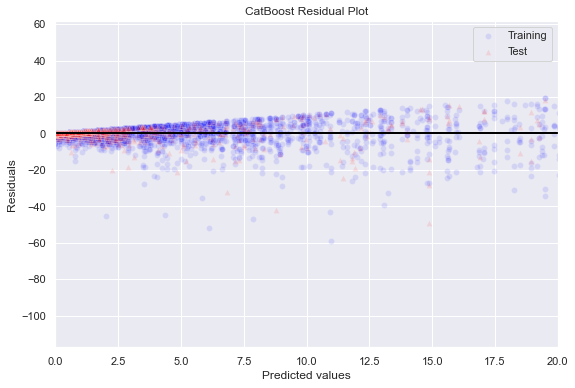

In [38]:
train_preds = model.predict(X_train)

residual_plot(y_train[:10000], train_preds[:10000],
              y_valid[:10000], y_pred[:10000],
              title="CatBoost Residual Plot")

## Features Importance

Text(0.5, 1.0, 'CatBoost features importance:')

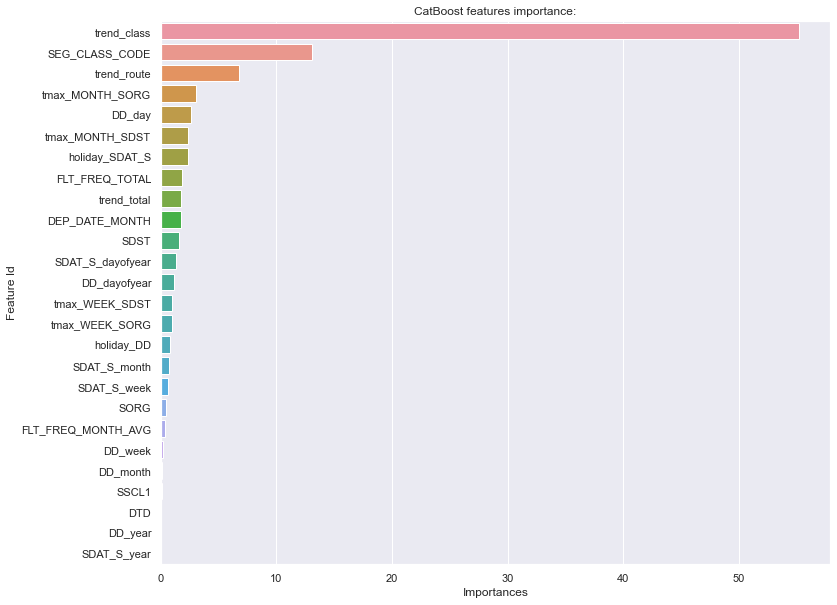

In [39]:
feat_importances = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

In [40]:
train_data = Pool(data=X_train, label=y_train, cat_features=np.where(X_train.dtypes == 'category')[0])
val_data = Pool(data=X_valid, label=y_valid, cat_features=np.where(X_valid.dtypes == 'category')[0])

In [41]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

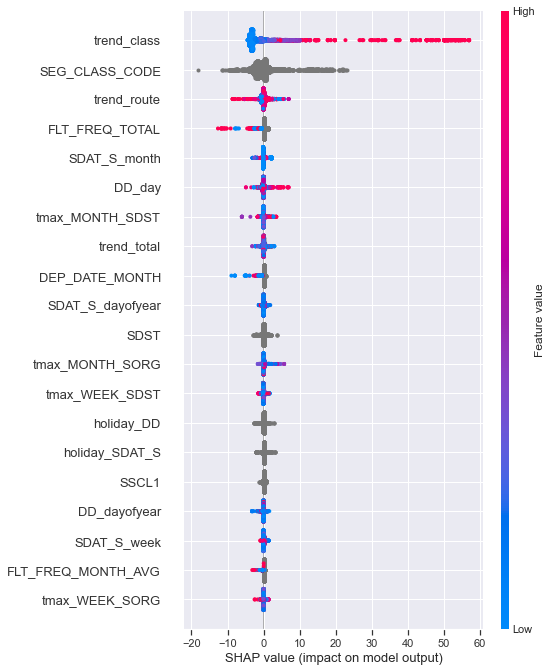

In [42]:
shap.summary_plot(shap_values, X_train)

Research Results of Feature Importance:
As it can be seen from feature importance analysis, the most important feature is, surprisingly, class seasonality. Second place takes class code, which is tightly connected to final price of the flight and thus raise no question as to why it takes second position (simply put - the more expensive tickets are the fewer people are buying them). Other important factors to consider are route seasonality, flight frequency, date features (that also represent some seasonality), and, finally, temperature of destination and origination points.

Further steps to work on:
1) Take social events into account (such as Formula-1, or big concerts);
2) Upload cities embedding into model that would characterize cities' business, cultural, and resort capacities;
3) Cities statistics on bar amount, crime rate